# LightGBM
## Import Libraries

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [4]:
from Utils import plot_correlation_heatmap, plot_mi_heatmap, plotMetricsGraphComparison
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, export_final_selected_features_to_csv

## Import Train and Test Datasets

In [5]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [6]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_train, Y_train_pred),
        "Precision": precision_score(Y_train, Y_train_pred),
        "Recall": recall_score(Y_train, Y_train_pred),
        "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In this notebook, we will explore LightGBM, another gradient boosting framework renowned for its efficiency and speed. LightGBM employs a unique tree-based learning algorithm that splits the tree leaf-wise instead of level-wise. This approach reduces the number of nodes to be split, resulting in faster training times. Additionally, LightGBM offers support for advanced features such as categorical feature optimization and parallel training.

The model will undergo several stages. Initially, it will be trained using all available features with default settings. Subsequently, we will apply feature selection methods to identify the optimal set of features and perform hyperparameter tuning to fine-tune the model's performance. Throughout each stage, we will observe and compare the model's performance.

Given its similarity to Gradient Boosting, we will employ similar methods for feature selection, utilizing techniques such as permutation importance and in-built feature importance scores. Similarly, hyperparameter tuning will involve tuning each hyperparameter separately to optimize the model's performance.

In [61]:
# Set up a dataframe to store the results from different versions
train_metrics_lgbm = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics_lgbm = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Build the Baseline Model before Feature Engineering

In [8]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [9]:
X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [10]:
lgbm_basic = LGBMClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [11]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = lgbm_basic.predict(X_train_basic)
Y_test_pred_basic = lgbm_basic.predict(X_test_basic)

In [62]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8985876814437034
Precision 	: 0.9121703853955375
Recall 		: 0.8821106316202433
F1 Score 	: 0.8968887116074991

**Test Set Metrics**
Accuracy 	: 0.8280332681017613
Precision 	: 0.6339805825242718
Recall 		: 0.3882282996432818
F1 Score 	: 0.48156342182890854


## Build the Baseline Model after Feature Engineering

In [13]:
lgbm = LGBMClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [14]:
# Predict the output based on our training and testing dataset
Y_train_pred = lgbm.predict(X_train)
Y_test_pred = lgbm.predict(X_test)

In [63]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.892114554727344
Precision 	: 0.9089607201309329
Recall 		: 0.8715182424480188
F1 Score 	: 0.8898457840977368

**Test Set Metrics**
Accuracy 	: 0.8226516634050881
Precision 	: 0.5780619111709286
Recall 		: 0.5107015457788348
F1 Score 	: 0.5422979797979798


From the results, we can see a great improvement in model performance after feature engineering.

## Eliminate the Features with permutation_importance=0

This step aims to remove features that do not contribute to the model's ability to capture meaningful patterns in the data.

In [16]:
feature_importances, feature_names = compute_permutation_importance(lgbm, X_train, Y_train)

In [17]:
# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

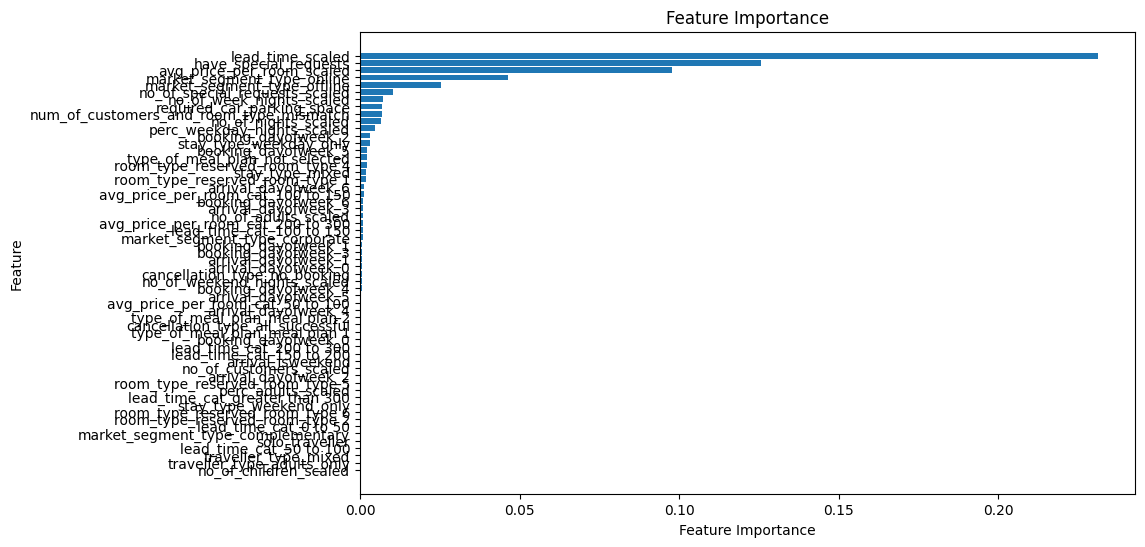

In [18]:
# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [19]:
selected_columns = feature_names

## Fit the Model again with the selected set of features

In [20]:
lgbm_selected = LGBMClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [21]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = lgbm_selected.predict(X_train[selected_columns])
Y_test_pred_selected = lgbm_selected.predict(X_test[selected_columns])

In [36]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.892114554727344
Precision 	: 0.9089607201309329
Recall 		: 0.8715182424480188
F1 Score 	: 0.8898457840977368

**Test Set Metrics**
Accuracy 	: 0.8264432485322897
Precision 	: 0.5925404644616468
Recall 		: 0.5005945303210464
F1 Score 	: 0.5427006123106671


## Eliminate Features with low in-built feature importance

This step involves leveraging the in-built feature importance score to gain insights into how each feature interacts with our model. To determine the optimal number of features to retain, we employ an iterative approach. Beginning with the most important feature, we incrementally add features to train the model. Subsequently, we plot the evaluation metrics across different numbers of features. The f1 score is selected as the primary metric for evaluation during this process.

In [22]:
# Initialize variables to store the best F1 score and corresponding set of features
best_f1_score = 0
best_num_features = 0
best_feature_set_1 = []

# Initialize lists to store the F1 scores and the number of features
f1_scores = []
num_features_selected = []

# Sort feature importances in descending order
feature_importances = lgbm_selected.feature_importances_
sorted_indices = (-feature_importances).argsort()

# Train the gradient boosting classifier on subsets of features
for i in range(1, len(selected_columns) + 1):
    # Select top 'i' features based on sorted indices
    top_features = selected_columns[sorted_indices[:i]]
    lgbm = LGBMClassifier(random_state=47)
    lgbm.fit(X_train[top_features], Y_train.values.ravel())
    
    # Make predictions on the test dataset
    Y_train_pred = lgbm.predict(X_train[top_features])
    
    # Calculate the F1 score
    f1 = f1_score(Y_train, Y_train_pred)
    
    # Update the best F1 score and corresponding set of features if necessary
    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = i
        best_feature_set_1 = top_features
    
    # Append the F1 score and the number of features selected
    f1_scores.append(f1)
    num_features_selected.append(i)

Best set of features: Index(['avg_price_per_room_scaled', 'lead_time_scaled',
       'no_of_special_requests_scaled', 'no_of_nights_scaled',
       'no_of_week_nights_scaled', 'market_segment_type_offline',
       'perc_weekday_nights_scaled', 'market_segment_type_online',
       'required_car_parking_space', 'no_of_weekend_nights_scaled',
       'num_of_customers_and_room_type_mismatch',
       'room_type_reserved_room_type 4', 'booking_dayofweek_2',
       'stay_type_mixed', 'room_type_reserved_room_type 1',
       'no_of_adults_scaled', 'solo_traveller', 'arrival_dayofweek_6',
       'avg_price_per_room_cat_200 to 300', 'booking_dayofweek_3',
       'type_of_meal_plan_meal plan 2', 'arrival_dayofweek_0',
       'market_segment_type_corporate', 'booking_dayofweek_1',
       'arrival_isweekend', 'booking_dayofweek_6', 'arrival_dayofweek_3',
       'cancellation_type_no_booking', 'arrival_dayofweek_4',
       'booking_dayofweek_5', 'booking_dayofweek_0',
       'type_of_meal_plan_meal 

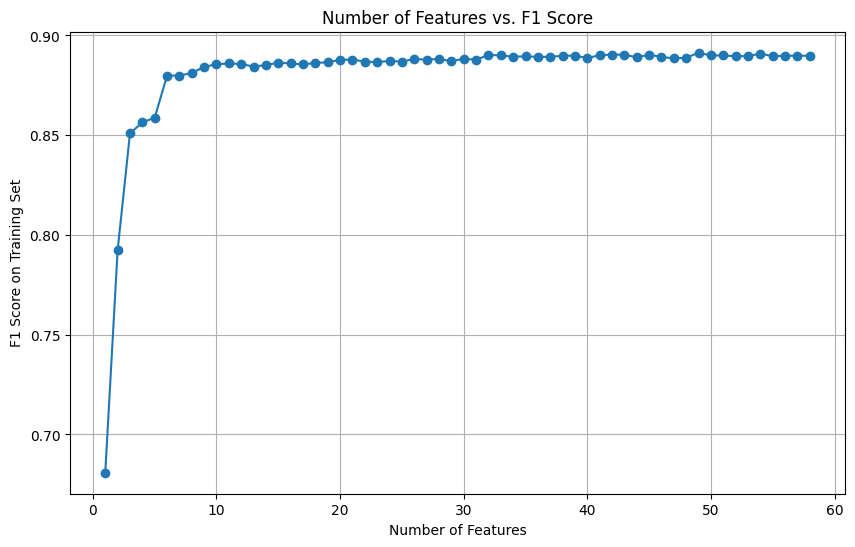

In [23]:
# Plot the number of features vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, f1_scores, marker='o', linestyle='-')
plt.title('Number of Features vs. F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score on Training Set')
plt.grid(True)

# Print the best set of features and the corresponding number of features
print("Best set of features:", best_feature_set_1)
print("Number of features:", best_num_features)
print("Best F1 score:", best_f1_score)

plt.show()

Rather than retaining the exact number of features that yield the optimal F1 score, we opt to keep the top 12 features. The performance improvement after this is much more subtle and selecting a smaller number helps reduce the dimensionality of the feature space, enhancing computational efficiency and potentially mitigating overfitting concerns.

In [24]:
# Get feature importance score
feature_importances = lgbm_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Get indices that would sort feature importances
sorted_indices = np.argsort(-feature_importances)

# Retain the top 12 features
feature_names = feature_names[sorted_indices[:12]]
feature_importances = feature_importances[sorted_indices[:12]]

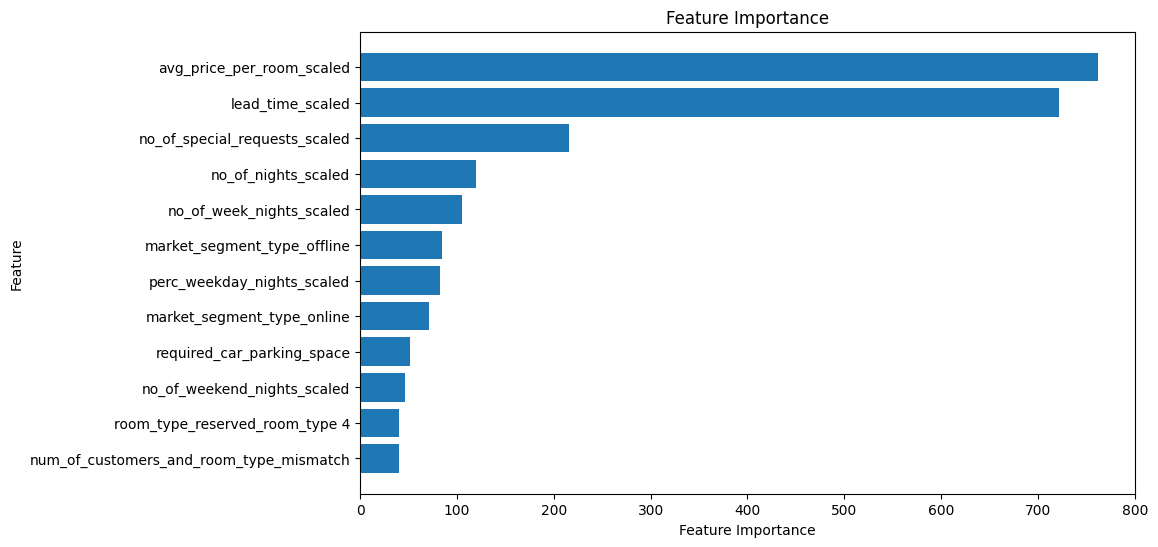

In [25]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

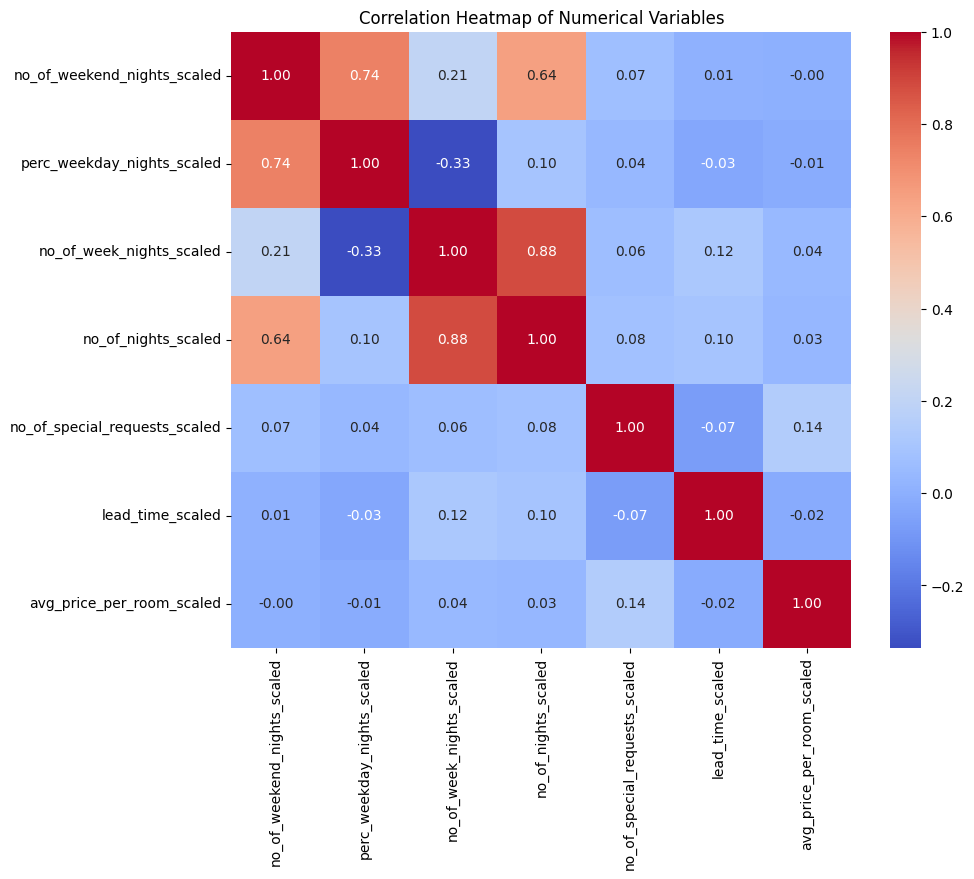

In [26]:
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
plot_correlation_heatmap(X_train[num_cols])

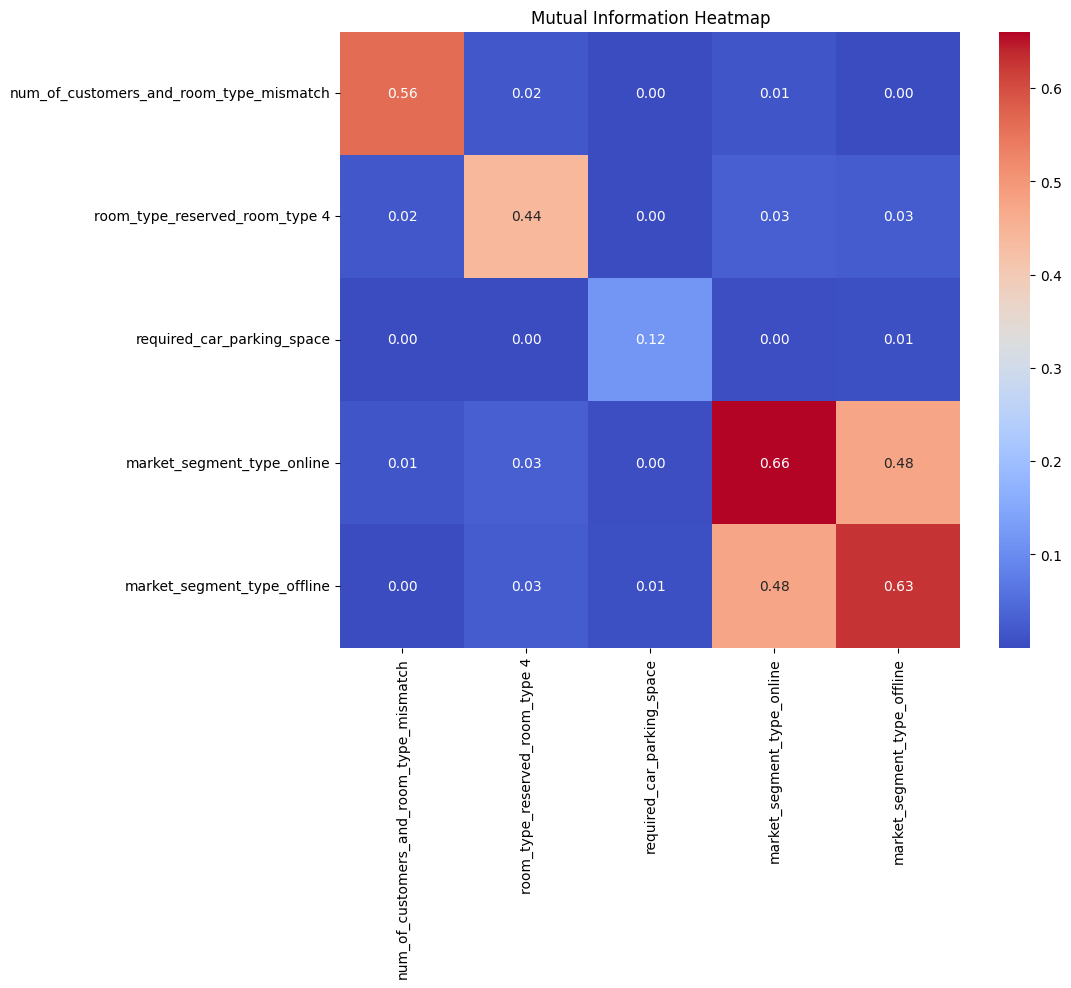

In [27]:
cat_cols = [x for x in feature_names[sorted_indices] if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled', 'no_of_week_nights_scaled', and 'market_segment_type_offline' have higher correlation with some other features and will be removed.

In [28]:
to_remove = ['no_of_nights_scaled', 'no_of_week_nights_scaled', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

## Fit the model with the final set of features

In [38]:
lgbm_selected_final = LGBMClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [39]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = lgbm_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = lgbm_selected_final.predict(X_test[final_columns])

In [64]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8846606512357787
Precision 	: 0.9028348397699261
Recall 		: 0.8621027854060416
F1 Score 	: 0.8819987959060807

**Test Set Metrics**
Accuracy 	: 0.8265655577299413
Precision 	: 0.5891891891891892
Recall 		: 0.5184304399524375
F1 Score 	: 0.551549652118912


## Hyperparameter Tuning

For LightGBM, there are several hyperparameters to tune:
1. num_leaves (default=31): Maximum tree leaves for base learners controls the maximum number of leaves in each tree. Higher values can increase model complexity but may also lead to overfitting.
2. max_depth (default=-1): Maximum depth of tree. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
3. learning_rate (default=0.1): Learning rate determines the step size at each iteration while moving towards a minimum of the loss function. Lower values require more iterations but can lead to better convergence.
4. n_estimators (default=100): The number of boosting rounds or iterations. Increasing the n_estimators parameter generally improves the performance of the model, but adding too many trees can lead to overfitting.
5. min_child_samples (default=20): The minimum number of samples required to be in a leaf (terminal node) of the tree during the training process. It controls the trade-off between model complexity and generalization performance.
Minimum loss reduction required to make a further partition on a leaf node of the tree. Increasing this value can help prevent overfitting.
6. max_bin (default=255):  The maximum number of bins used to discretize continuous features. Increasing max_bin can improve the model's performance by enabling it to learn more complex relationships in the data. However, it also increases the computational cost and may lead to overfitting if the number of bins becomes too large relative to the size of the dataset.
7. reg_lambda (default=0): L2 regularization term on weights. This penalty term helps prevent overfitting by discouraging large weights.

### Tune num_leaves

In [259]:
parameters_num_leaves = {
    'num_leaves': range(20, 100, 10),
    }
model = LGBMClassifier(random_state=47)
grid_search_num_leaves = GridSearchCV(model, param_grid=parameters_num_leaves, cv=5, scoring='f1', verbose=1)
grid_search_num_leaves.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=47),
             param_grid={'num_leaves': range(20, 100, 10)}, scoring='f1',
             verbose=1)

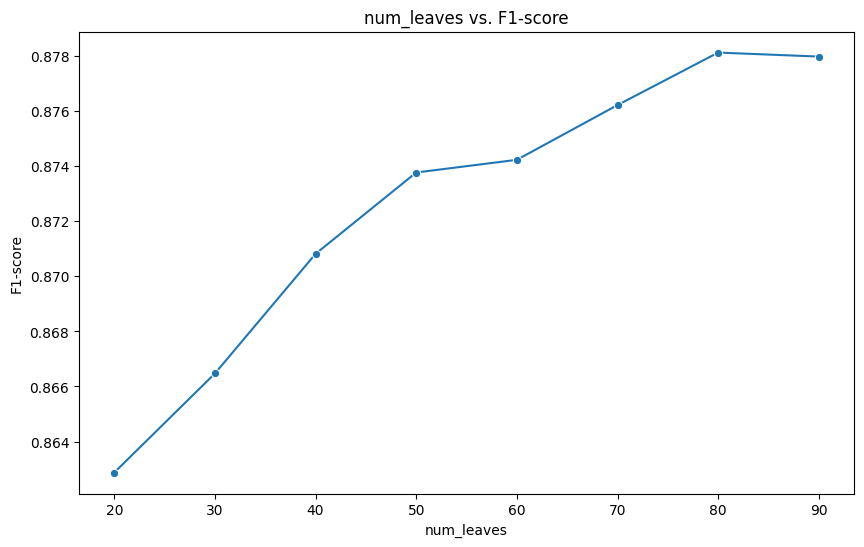

In [260]:
plt.figure(figsize=(10, 6))

# Plotting num_leaves vs. f1
sns.lineplot(x=list(range(20, 100, 10)), y=grid_search_num_leaves.cv_results_['mean_test_score'], marker='o')
plt.title('num_leaves vs. F1-score')
plt.xlabel('num_leaves')
plt.ylabel('F1-score')
plt.show()

Although the model's performance tends to improve with an increase in the number of leaves, to mitigate the risk of overfitting, we decide to set the num_leaves parameter to 50.

### Tune max_depth

In [264]:
parameters_max_depth = {
    'max_depth': range(2, 15, 1),
    }
model = LGBMClassifier(num_leaves=50, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(num_leaves=50, random_state=47),
             param_grid={'max_depth': range(2, 15)}, scoring='f1', verbose=1)

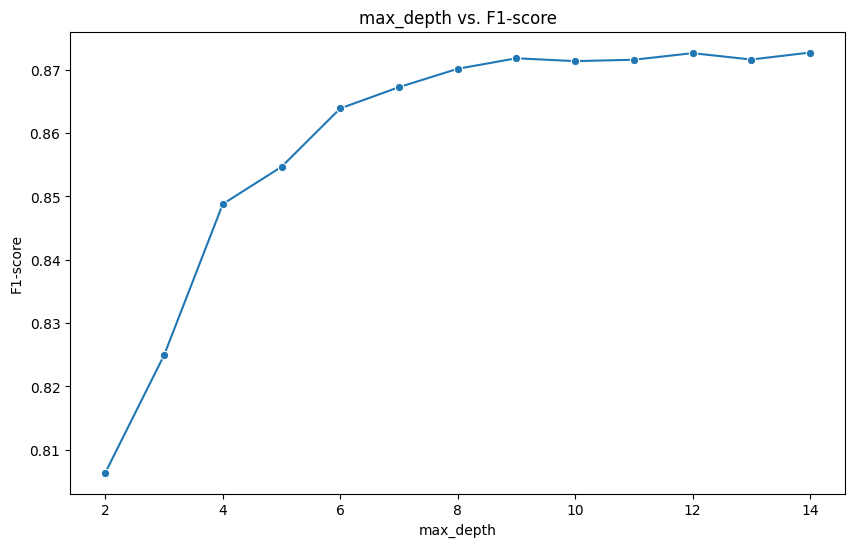

In [265]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=list(range(2, 15, 1)), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

The model's performance reaches its peak with max_depth=6, with marginal improvements observed beyond this point. Consequently, we opt to set max_depth=6 to achieve optimal performance.

### Tune learning_rate and n_estimators

In [266]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'n_estimators': range(50, 150, 10)
    }
model = LGBMClassifier(num_leaves=50, max_depth=6, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=50,
                                      random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'n_estimators': range(50, 150, 10)},
             scoring='f1', verbose=1)

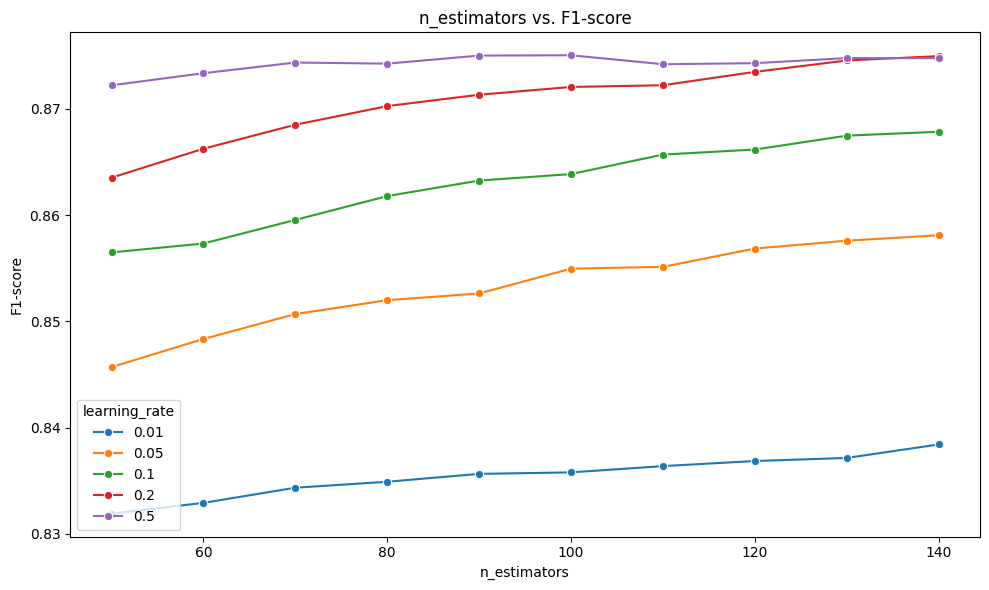

In [267]:
plt.figure(figsize=(10, 6))

# Plotting learning_rate, n_estimators vs. f1
for i in range(5):
    sns.lineplot(x=range(50, 150, 10), y=grid_search_learning_rate.cv_results_['mean_test_score'][list(range(i*10, 10+i*10, 1))], marker='o', label=f"{['0.01', '0.05', '0.1', '0.2', '0.5'][i]}")
plt.title(f'n_estimators vs. F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score')
plt.legend(title="learning_rate") 
plt.tight_layout()
plt.show()

Altering n_estimators does not introduces much difference to the model performance. The default value of learning_rate=0.1 demonstrates a desirable performance. Lower values could lead to a slower learning process, as evidenced by the lower f1 score. Conversely, increasing the learning rate does not significantly improve performance. Therefore, we decide to retain the default value of n_estimator and learning_rate for optimal results.

### Tune min_child_samples

In [268]:
parameters_min_child_samples = {
    'min_child_samples': range(5, 50, 5)
    }
model = LGBMClassifier(num_leaves=50, max_depth=6, learning_rate=0.1, n_estimators=100, random_state=47)
grid_search_min_child_samples = GridSearchCV(model, param_grid=parameters_min_child_samples, cv=5, scoring='f1', verbose=1)
grid_search_min_child_samples.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=50,
                                      random_state=47),
             param_grid={'min_child_samples': range(5, 50, 5)}, scoring='f1',
             verbose=1)

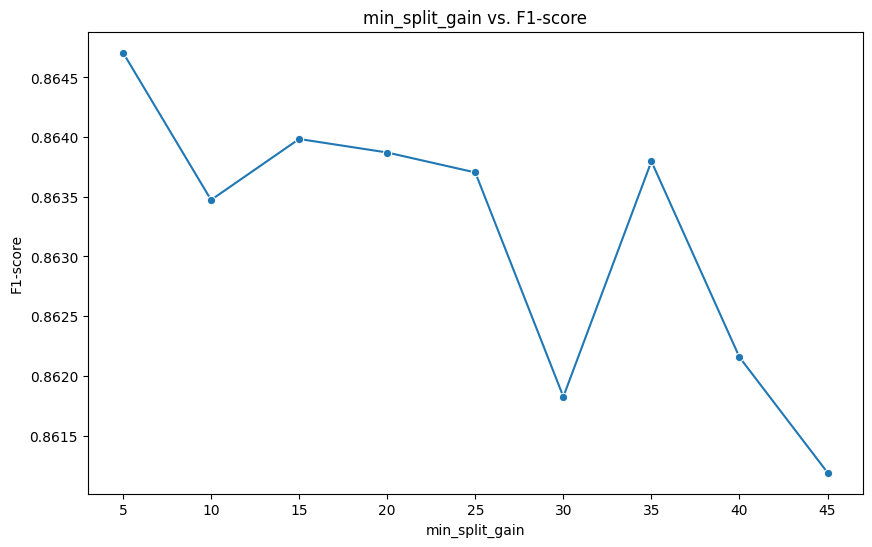

In [269]:
plt.figure(figsize=(10, 6))

# Plotting min_child_samples vs. f1
sns.lineplot(x=range(5, 50, 5), y=grid_search_min_child_samples.cv_results_['mean_test_score'], marker='o')
plt.title('min_split_gain vs. F1-score')
plt.xlabel('min_split_gain')
plt.ylabel('F1-score')
plt.show()

min_child_samples=5 provides the best performance, as shown above.

### Tune max_bin

In [305]:
parameters_max_bin = {
    'max_bin': range(50, 500, 50)
    }
model = LGBMClassifier(num_leaves=50, max_depth=6, learning_rate=0.1, n_estimators=100, min_child_samples=5, random_state=47)
grid_search_max_bin = GridSearchCV(model, param_grid=parameters_max_bin, cv=5, scoring='f1', verbose=1)
grid_search_max_bin.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, min_child_samples=5,
                                      num_leaves=50, random_state=47),
             param_grid={'max_bin': range(50, 500, 50)}, scoring='f1',
             verbose=1)

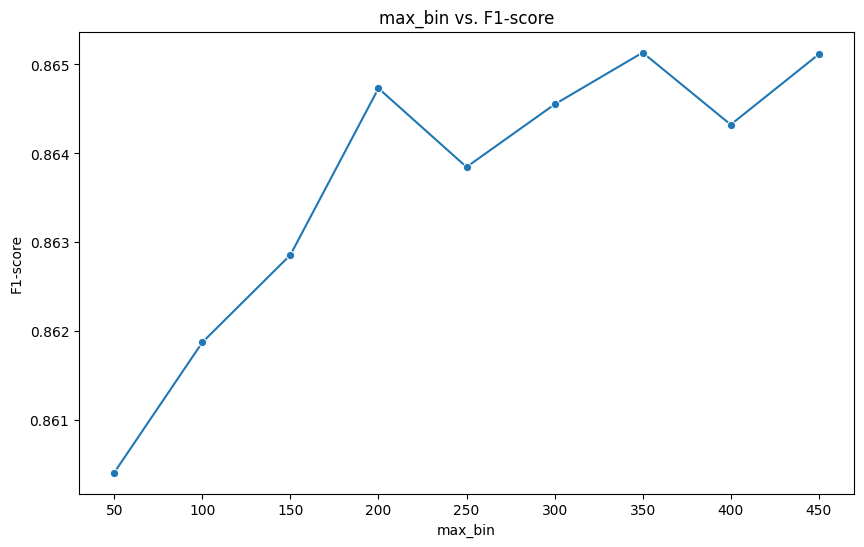

In [306]:
plt.figure(figsize=(10, 6))

# Plotting colsample_bytree vs. f1
sns.lineplot(x=range(50, 500, 50), y=grid_search_max_bin.cv_results_['mean_test_score'], marker='o')
plt.title('max_bin vs. F1-score')
plt.xlabel('max_bin')
plt.ylabel('F1-score')
plt.show()

Reducing max_bin to 200 results in a more consistent performance. However, as max_bin is increased beyond this threshold, the performance becomes less stable, with no discernible improvement observed. This suggests that higher values of max_bin may introduce additional noise into the model, leading to fluctuations in performance without providing significant benefits in terms of predictive accuracy or generalization.

### Tune reg_lambda

In [307]:
parameters_reg = {
    'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]
    }
model = LGBMClassifier(num_leaves=50, max_depth=6, learning_rate=0.1, n_estimators=200, min_child_samples=5, max_bin=200, random_state=47)
grid_search_reg = GridSearchCV(model, param_grid=parameters_reg, cv=5, scoring='f1', verbose=1)
grid_search_reg.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_bin=200, max_depth=6,
                                      min_child_samples=5, n_estimators=200,
                                      num_leaves=50, random_state=47),
             param_grid={'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]},
             scoring='f1', verbose=1)

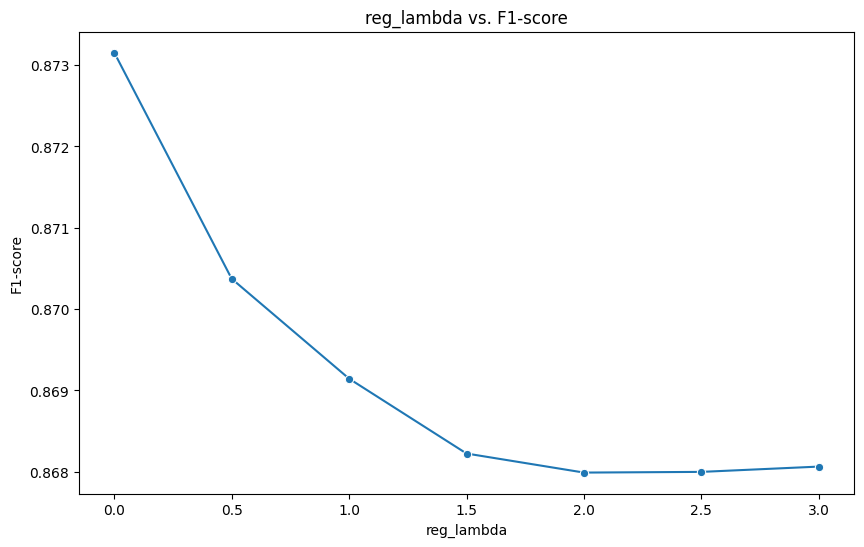

In [308]:
plt.figure(figsize=(10, 6))

# Plotting reg_lambda vs. f1
sns.lineplot(x=[0, 0.5, 1, 1.5, 2, 2.5, 3], y=grid_search_reg.cv_results_['mean_test_score'], marker='o')
plt.title('reg_lambda vs. F1-score')
plt.xlabel('reg_lambda')
plt.ylabel('F1-score')
plt.show()

While introducing regularization will reduce the f1 score for training set, to reduce overfitting, we will set reg_lambda=2.

## Fit the Model again the tuned hyperparameters

In [32]:
lgbm_tuned = LGBMClassifier(num_leaves=50, max_depth=6, min_child_samples=5, max_bin=200, reg_lambda=2).fit(X_train[final_columns], Y_train.values.ravel())

In [33]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = lgbm_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = lgbm_tuned.predict(X_test[final_columns])

In [65]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8763730874852883
Precision 	: 0.8968048805707786
Recall 		: 0.8506276971361318
F1 Score 	: 0.8731061559369809

**Test Set Metrics**
Accuracy 	: 0.8299902152641878
Precision 	: 0.6020979020979021
Recall 		: 0.5118906064209274
F1 Score 	: 0.5533419023136246


## Evaluation

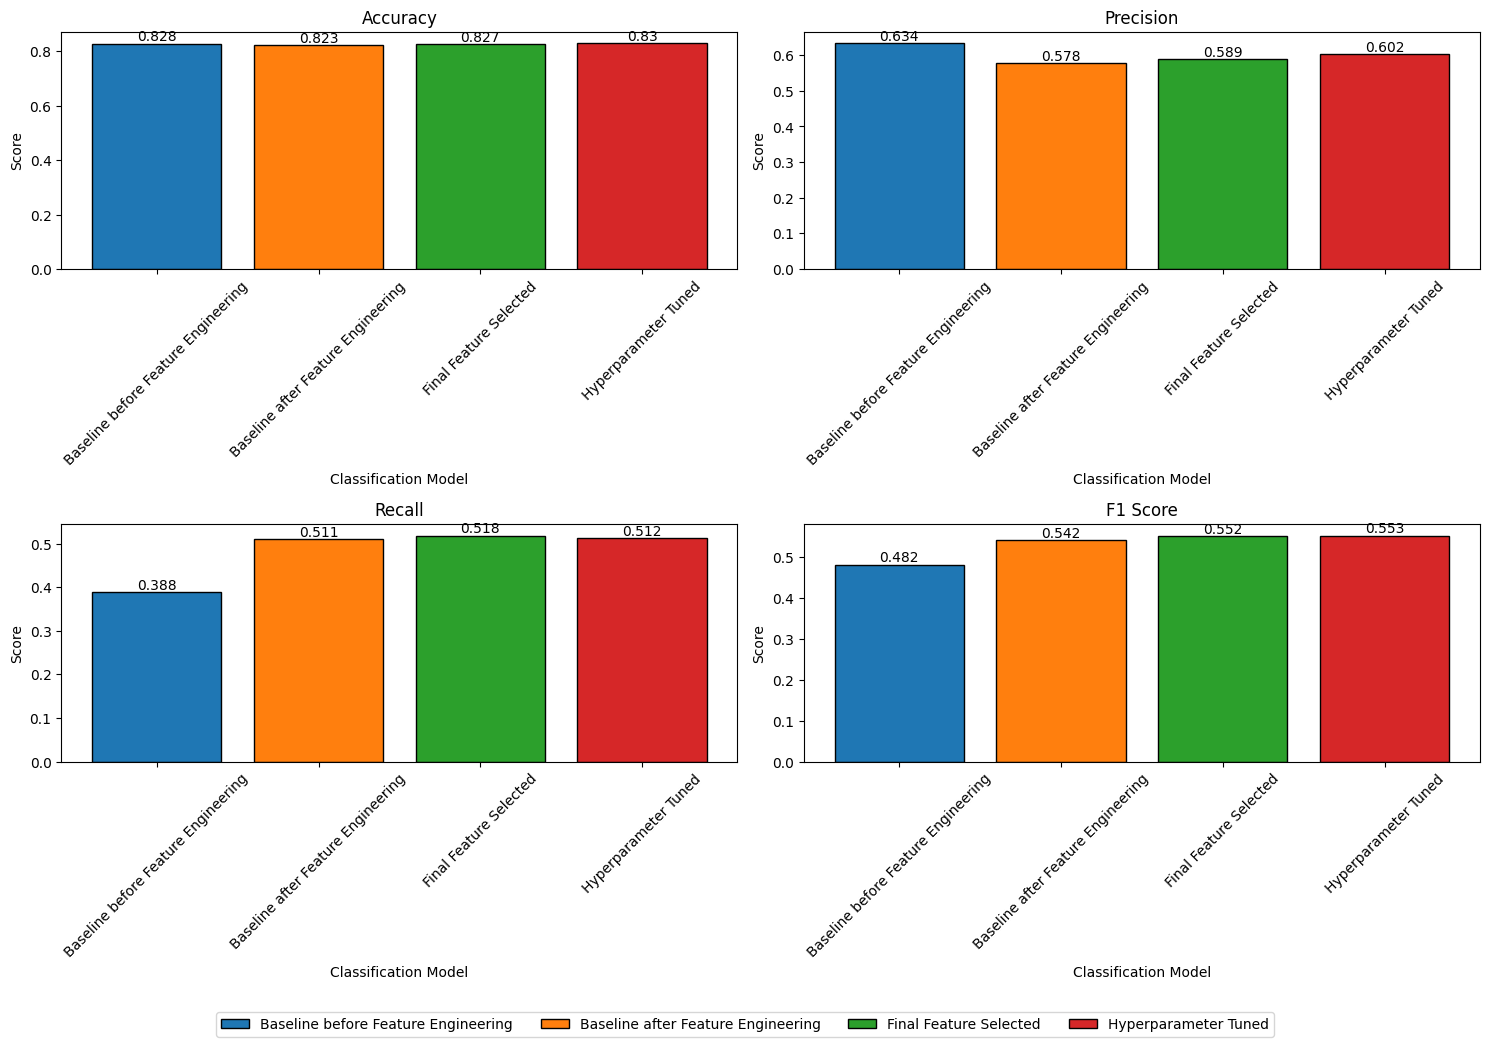

In [66]:
plotMetricsGraphComparison(test_metrics_lgbm)

LightGBM demonstrates a clear improvement in model performance over successive iterations. Notably, feature engineering emerges as the primary driver of enhanced performance, underscoring its critical role in refining the model's predictive capabilities. Additionally, the application of feature selection techniques contributes to improvements across all evaluation metrics. However, the impact of hyperparameter tuning on performance appears less pronounced, suggesting that the default settings are already adept at capturing the underlying patterns within the data. The overall trend in hyperparameter tuning is to decrease the complexity of weak learners and incorporate regularization techniques to mitigate overfitting.

Compared to Gradient Boosting, Light Gradient Boosting demonstrated a slightly better performance, with much less training time. This highlights the superiority of LightGBM, especially when dealing with large amount of data.

## Export

In [67]:
# export the features used for this model
export_final_selected_features_to_csv(final_columns, "Best LightGBM")


Features exported successfully to FinalModels/Feature_Selection/Best LightGBM


In [68]:
# export the best model to be compared later on
joblib.dump(lgbm_tuned, "FinalModels/BestLightGBM.pkl")

['FinalModels/BestLightGBM.pkl']

## Alternative Method: Bayesian Optimization

Bayesian Optimization is a probabilistic model-based optimization technique used to find the maximum or minimum of an objective function over a bounded domain. It is particularly useful when the objective function is expensive to evaluate and noisy, as it aims to find the optimum with as few evaluations as possible. By iteratively updating the surrogate model and selecting the next sampling point based on the acquisition function, Bayesian Optimization efficiently explores the parameter space and converges to the optimal solution with a minimal number of evaluations of the objective function.

In [ ]:
from bayes_opt import BayesianOptimization
import lightgbm

In [ ]:
data = lightgbm.Dataset(X_train[final_columns], label=Y_train.values.ravel())

# Define the objective function
def objective_function(num_leaves, max_depth, learning_rate, min_split_gain, subsample, colsample_bytree):
    params = {'application':'binary', 'metric':'auc', 'verbose':-1}
    params['num_leaves'] = int(num_leaves)
    params["max_depth"] = int(max_depth)
    params['learning_rate'] = round(learning_rate, 2)
    params['min_split_gain'] = round(min_split_gain, 2)
    params['subsample'] = round(subsample, 2)
    params['colsample_bytree'] = round(colsample_bytree, 2)
    
    cv_result = lightgbm.cv(params, data, nfold=5, seed=47, stratified=True, metrics=['auc'])
    return max(cv_result['auc-mean'])

# Specify the search space
search_space = {
    'num_leaves': (20, 50),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 1),
    'min_split_gain': (0.1, 1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Initialize the BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=search_space,
    random_state=47  # Optional: set random seed for reproducibility
)

# Run the optimization
optimizer.maximize(
    init_points=10,  # Number of random exploration points
    n_iter=100,      # Number of optimization iterations
)

# Retrieve the best hyperparameters
best_hyperparams = optimizer.max['params']

|   iter    |  target   | colsam... | learni... | max_depth | min_sp... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9341    | 0.5567    | 0.9747    | 8.101     | 0.4163    | 41.23     | 0.8998    |
| 2         | 0.9418    | 0.8228    | 0.4205    | 7.942     | 0.322     | 27.68     | 0.512     |
| 3         | 0.9386    | 0.5494    | 0.3074    | 7.486     | 0.39      | 25.56     | 0.9586    |
| 4         | 0.9436    | 0.6355    | 0.2808    | 9.681     | 0.2144    | 42.42     | 0.5026    |
| 5         | 0.9361    | 0.9284    | 0.699     | 6.871     | 0.9417    | 35.38     | 0.5888    |
| 6         | 0.9236    | 0.7684    | 0.3005    | 3.074     | 0.8954    | 39.69     | 0.9711    |
| 7         | 0.9365    | 0.8725    | 0.2745    | 5.533     | 0.5738    | 36.41     | 0.6293    |
| 8         | 0.9252    | 0.5873    | 0.3671    | 3.981     | 0.4502    | 34.16     | 0.9844    |
| 9         | 0.937 

In [ ]:
best_hyperparams

{'colsample_bytree': 1.0,
 'learning_rate': 0.2509404266555085,
 'max_depth': 10.0,
 'min_split_gain': 0.1,
 'num_leaves': 40.87047583742487,
 'subsample': 0.5}